Name: Charles Fawcett

Student ID: 14247617

In [216]:
#ALL import statements
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
from sklearn import tree, metrics


In [217]:
#ALL custom functions

def quartile_performance(data: pd.DataFrame, return_name: str = "fut_ret") -> pd.DataFrame:
    mean_return = data[return_name].mean()*12
    volatility = data[return_name].std()*np.sqrt(12)
    rr_ratio = (data[return_name].mean()*12) / (data[return_name].std()*np.sqrt(12)) #added brackets compared to tutorial
    performance = pd.DataFrame({'Mean Ret': mean_return,
                                'Std Dev': volatility,
                                'RR Ratio': rr_ratio})
    return performance

def one_dollar_invested_plot(df: pd.DataFrame, title: str, legend_map: dict | None = None, save_as: None | str = None) -> None:
    ax = df.plot(figsize=(10, 6))
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value ($, Log Scale)")
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))
    ax.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
    ax.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
    ax.tick_params(axis='x', labelrotation=0)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('center')
    ax.figure.tight_layout()

    # remap legend labels
    if legend_map is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, [legend_map.get(l, l) for l in labels])

    if save_as:
        ax.figure.savefig(save_as, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(ax.figure)

    

In [218]:
#Loading of ALL data files
factors = pd.read_csv('FACTORS.zip', parse_dates=['date']).set_index(['id', 'date'])
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])
names = pd.read_csv('names.zip').set_index('id')
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date'])
inflation = pd.read_csv('Inflation.csv', parse_dates=['date']).set_index(['date'])

factors.head()



C:\Users\cfawc\AppData\Local\Temp\ipykernel_9828\810976339.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inflation = pd.read_csv('Inflation.csv', parse_dates=['date']).set_index(['date'])


tvol    profit    safety
id    date                                    
10001 1996-07-31  1.145514 -0.612134 -0.475430
      1996-08-30  1.144505 -0.614493 -0.553341
      1996-09-30  1.144190 -1.327119 -0.697980
      1996-10-31  1.124252 -1.324461 -0.728012
      1996-11-29  1.123180 -1.321322 -0.721799

1. PREDICTIVE POWER OF INVESTMENT FACTORS


In [219]:
#calculating the future returns and storing this in a series
future_returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

#split each factor into their own series
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#number of bins for the quintile analysis
N = 4

#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)
data = groups.join(future_returns).dropna(subset=['fut_ret'])

data.tail()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
93426 2023-08-31           3             3             4 -0.070144
      2023-09-29           3             3             4 -0.115403
      2023-10-31           3             3             4  0.018872
      2023-11-30           3             3             4  0.111019
      2023-12-29           3             3             4 -0.066438

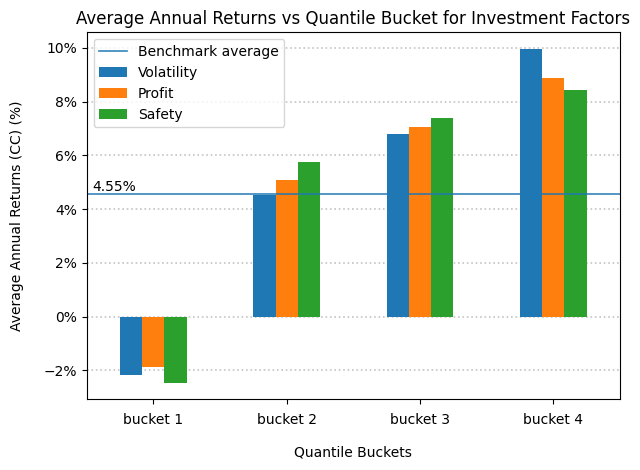

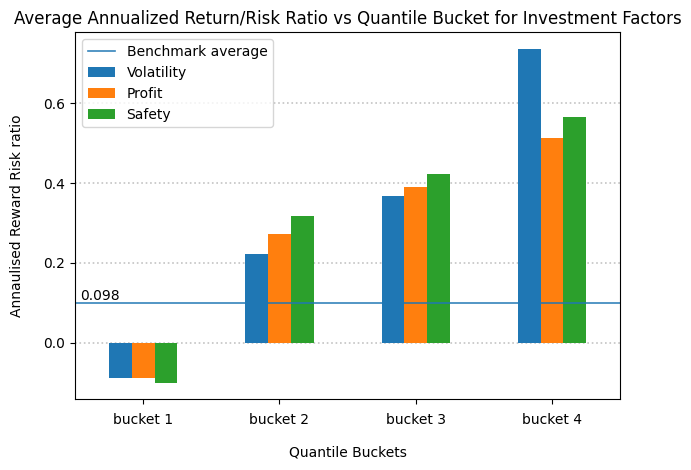

In [220]:
#calculate the average signal and the average future return and pass this to the quartile_performance function
tvol_perf = quartile_performance(tvol_data.groupby(['date', 'tvol_group']).mean().unstack(level=1))
profit_perf = quartile_performance(profit_data.groupby(['date', 'profit_group']).mean().unstack(level=1))
safety_perf = quartile_performance(safety_data.groupby(['date', 'safety_group']).mean().unstack(level=1))

#setup and creating the "Average Annual Returns vs Quantile Bucket for Investment Factors" graph (aar) ###########################################
#benchmark performance (using tvol)
avg_benchmark_returns = tvol_data['fut_ret'].mean()*12
benchmark_rr_ratio = (tvol_data['fut_ret'].mean()*12) / (tvol_data['fut_ret'].std()*np.sqrt(12))

bar_chart_col_names = [f"bucket {i+1}" for i in range(N)]
aar_bar_chart_df = pd.DataFrame({
    'Volatility': tvol_perf['Mean Ret'],
    'Profit': profit_perf['Mean Ret'],
    'Safety': safety_perf['Mean Ret']
})

aar_bar_chart_df.index = bar_chart_col_names

aar_bar_chart = aar_bar_chart_df.plot(kind='bar', rot=0)
aar_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
aar_bar_chart.set_ylabel("Average Annual Returns (CC) (%)", labelpad=14)
aar_bar_chart.set_title("Average Annual Returns vs Quantile Bucket for Investment Factors")
aar_bar_chart.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))

aar_bar_chart.axhline(y=avg_benchmark_returns, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark average')
aar_bar_chart.text(0.01, avg_benchmark_returns, f'{avg_benchmark_returns:.2%}',
        transform=aar_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
aar_bar_chart.legend()

aar_bar_chart.set_axisbelow(True)
aar_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in aar_bar_chart.get_xticklabels():
    lbl.set_ha('center')   # default for bars, but explicit is fine
aar_bar_chart.tick_params(axis='x', pad=6)  # a little space from the axis
aar_bar_chart.figure.tight_layout()

#setup and creating the "Risk to Reward ratio vs Quintile Bucket for Investment Factors" (rrr)
rrr_bar_chart = pd.DataFrame({
    'Volatility': tvol_perf['RR Ratio'],
    'Profit': profit_perf['RR Ratio'],
    'Safety': safety_perf['RR Ratio']
})

rrr_bar_chart.index = bar_chart_col_names

rrr_bar_chart = rrr_bar_chart.plot(kind='bar', rot=0)
rrr_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
rrr_bar_chart.set_ylabel("Annaulised Reward Risk ratio", labelpad=14)
rrr_bar_chart.set_title("Average Annualized Return/Risk Ratio vs Quantile Bucket for Investment Factors")

rrr_bar_chart.axhline(y=benchmark_rr_ratio, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark average')
rrr_bar_chart.text(0.01, benchmark_rr_ratio, f'{benchmark_rr_ratio:.2}',
        transform=rrr_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
rrr_bar_chart.legend()

rrr_bar_chart.set_axisbelow(True)
rrr_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in rrr_bar_chart.get_xticklabels():
    lbl.set_ha('center')
rrr_bar_chart.tick_params(axis='x', pad=6)
rrr_bar_chart.figure.tight_layout()



In [221]:
data.head()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
10001 1996-07-31           4             1             2  0.037458
      1996-08-30           4             1             2  0.040916
      1996-09-30           4             1             1 -0.028987
      1996-10-31           4             1             1  0.028988
      1996-11-29           4             1             1 -0.061268

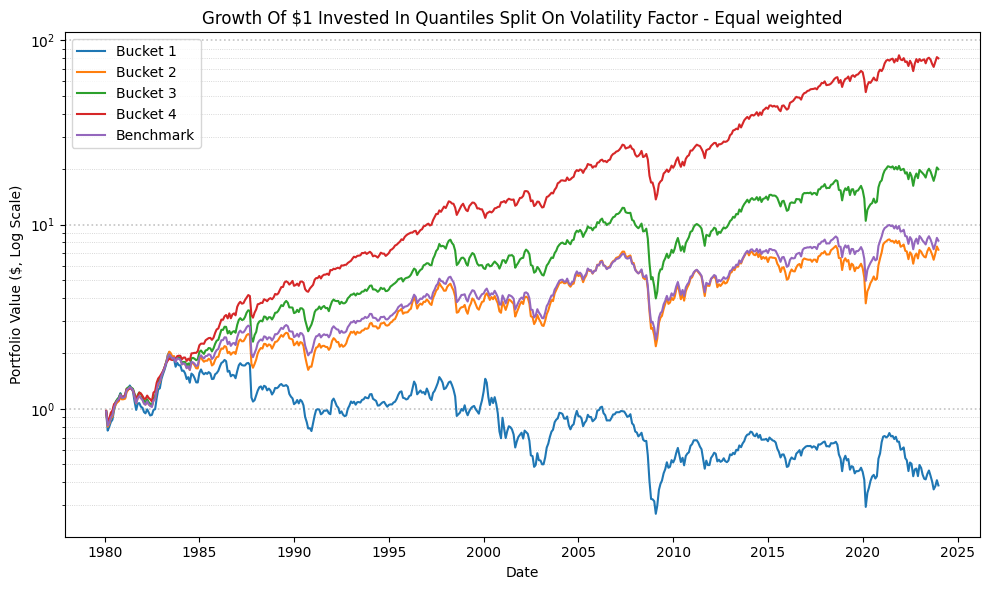

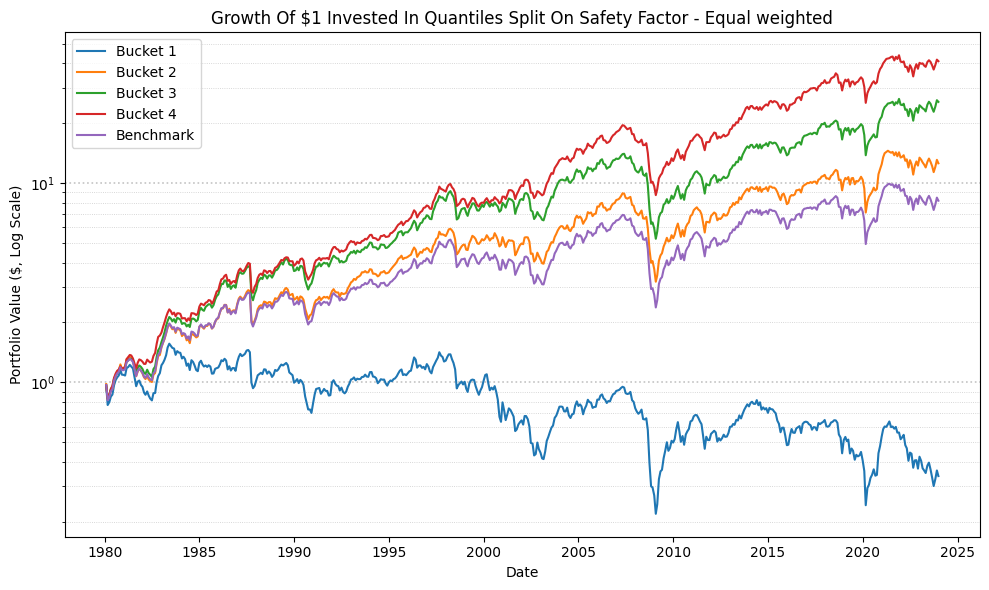

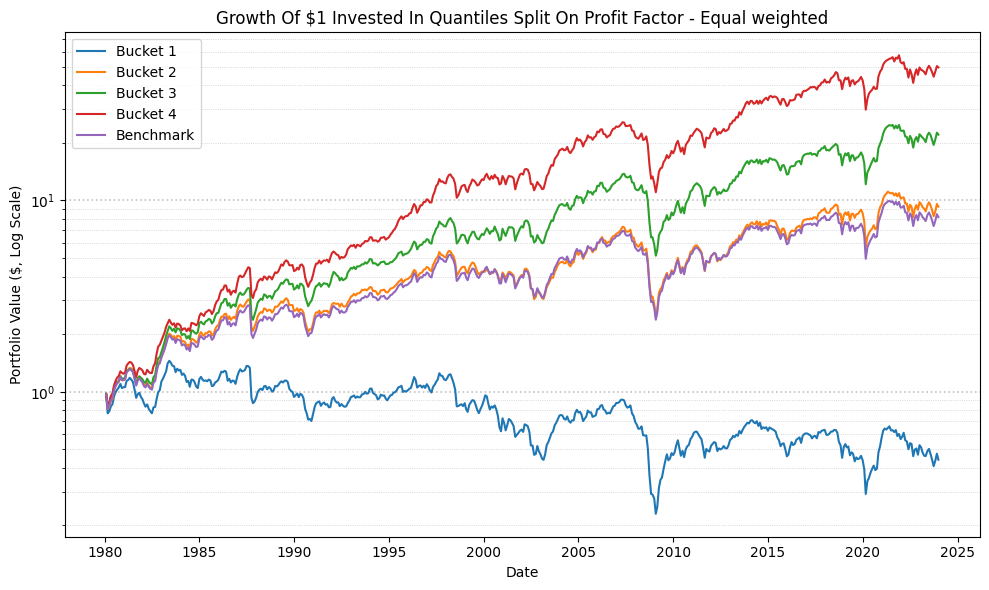

In [222]:
#now let's visualise the returns on a $1 portfolio in each bucket and factor
bench_port = data['fut_ret'].groupby('date').mean().cumsum().apply(np.exp).to_frame()
tvol_port = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
tvol_port = tvol_port.join(bench_port)
safety_port = data.groupby(['date', 'safety_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
safety_port = safety_port.join(bench_port)
profit_port = data.groupby(['date', 'profit_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
profit_port = profit_port.join(bench_port)

legend_map = {}
for i in range(0, N):
    legend_map[f"{i+1}"] = f"Bucket {i+1}"
legend_map["fut_ret"] = "Benchmark"

#plot each factor
one_dollar_invested_plot(tvol_port, "Growth Of $1 Invested In Quantiles Split On Volatility Factor - Equal weighted", legend_map=legend_map)
one_dollar_invested_plot(safety_port, "Growth Of $1 Invested In Quantiles Split On Safety Factor - Equal weighted", legend_map=legend_map)
one_dollar_invested_plot(profit_port, "Growth Of $1 Invested In Quantiles Split On Profit Factor - Equal weighted", legend_map=legend_map)

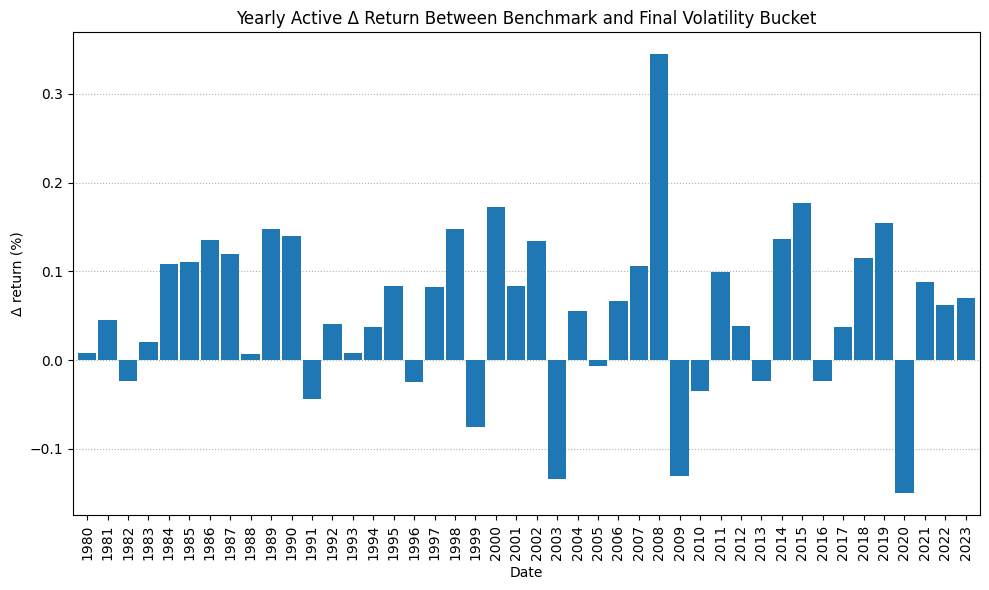

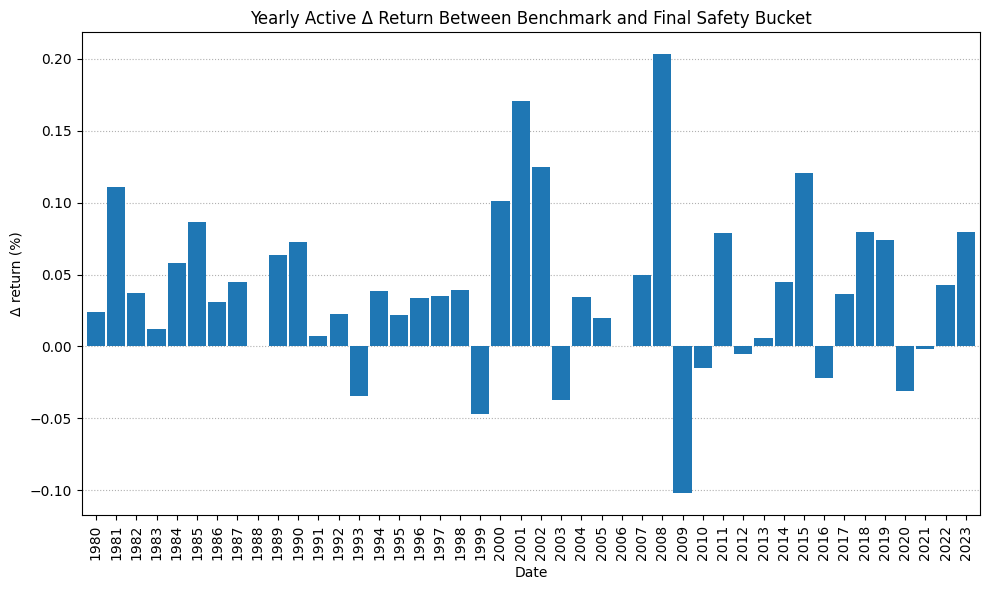

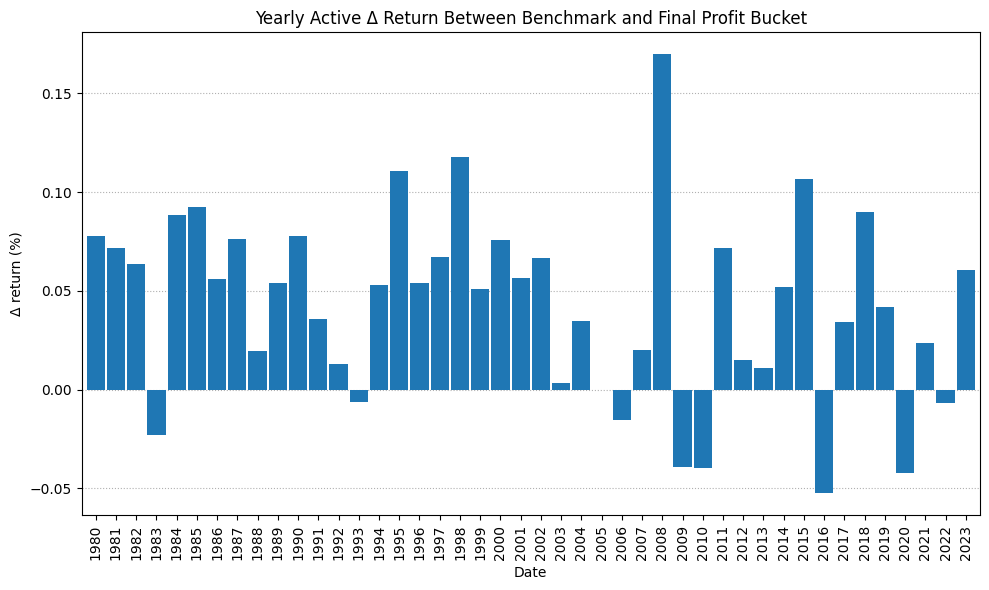

In [223]:
#let's take a closer look at the year by year performance by looking at the differnce between bucket 4 and the benchmark year by year for each factor

benchmark_ret = data['fut_ret'].groupby('date').mean().to_frame()

#yby for year by year
tvol_active = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)["fut_ret"]
tvol_active = tvol_active.join(benchmark_ret).dropna()
tvol_active["active"] = tvol_active[N] - tvol_active["fut_ret"]
tvol_yby = tvol_active.resample('YE').sum().apply(np.expm1)
tvol_yby.index = tvol_yby.index.year

safety_active = data.groupby(['date', 'safety_group']).mean().unstack(level=1)["fut_ret"]
safety_active = safety_active.join(benchmark_ret).dropna()
safety_active["active"] = safety_active[N] - safety_active["fut_ret"]
safety_yby = safety_active.resample('YE').sum().apply(np.expm1)
safety_yby.index = safety_yby.index.year

profit_active = data.groupby(['date', 'profit_group']).mean().unstack(level=1)["fut_ret"]
profit_active = profit_active.join(benchmark_ret).dropna()
profit_active["active"] = profit_active[N] - profit_active["fut_ret"]
profit_yby = profit_active.resample('YE').sum().apply(np.expm1)
profit_yby.index = profit_yby.index.year

#take the active returns and put them in a dataframe for future use
actives = pd.DataFrame()
actives["tvol"] = tvol_active['active'] 
actives["safety"] = safety_active['active'] 
actives["profit"] = profit_active['active'] 

#bar charts
tvol_yby_bar_return = tvol_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
tvol_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Volatility Bucket")
tvol_yby_bar_return.set_xlabel("Date")
tvol_yby_bar_return.set_ylabel("Δ return (%)")
tvol_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
tvol_yby_bar_return.set_axisbelow(True)
plt.tight_layout()
plt.show()

safety_yby_bar_return = safety_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
safety_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Safety Bucket")
safety_yby_bar_return.set_xlabel("Date")
safety_yby_bar_return.set_ylabel("Δ return (%)")
safety_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
safety_yby_bar_return.set_axisbelow(True)
plt.tight_layout()
plt.show()

profit_yby_bar_return = profit_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
profit_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Profit Bucket")
profit_yby_bar_return.set_xlabel("Date")
profit_yby_bar_return.set_ylabel("Δ return (%)")
profit_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
profit_yby_bar_return.set_axisbelow(True)
plt.tight_layout()
plt.show()




Text(0.5, 1.0, 'Rolling 3 Year Correlation Between Returns of Investment in Top Factor Bucket Stocks')

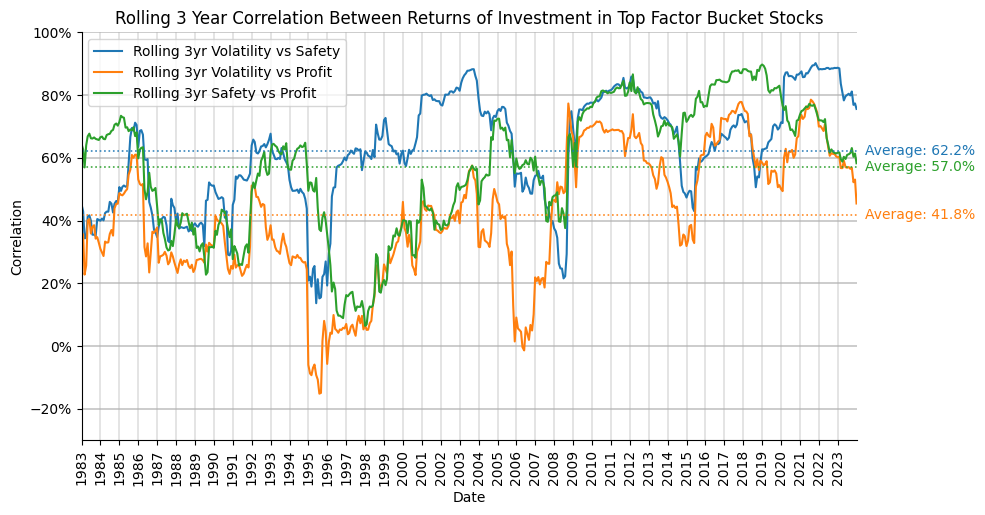

In [224]:
#now to calculate the correlation between the factors!
roll_corr = pd.DataFrame()
roll_corr['tvol_safety'] = actives['tvol'].rolling(36).corr(actives['safety'])
roll_corr['tvol_profit'] = actives['tvol'].rolling(36).corr(actives['profit'])
roll_corr['safety_profit'] = actives['safety'].rolling(36).corr(actives['profit'])

averages = [roll_corr['tvol_safety'].mean(), roll_corr['tvol_profit'].mean(), roll_corr['safety_profit'].mean()]

roll_corr_plot = roll_corr.plot(figsize=(10, 6))
roll_corr_plot.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
roll_corr_plot.set_ylim(-.3, 1)
roll_corr_plot.tick_params(axis='x', labelrotation=90)
roll_corr_plot.spines['top'].set_visible(False)
roll_corr_plot.spines['right'].set_visible(False)
first_valid = roll_corr.index[roll_corr.notna().any(axis=1)][0]
roll_corr_plot.xaxis.set_major_locator(mdates.YearLocator(base=1, month=1, day=1))
roll_corr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
roll_corr_plot.set_xlim(left=first_valid, right=roll_corr.index.max())  # no extra room on the right
roll_corr_plot.margins(x=0) 

legend_map = {
        "tvol_safety" : "Rolling 3yr Volatility vs Safety",
        "tvol_profit" : "Rolling 3yr Volatility vs Profit",
        "safety_profit" : "Rolling 3yr Safety vs Profit",
}
handles, labels = roll_corr_plot.get_legend_handles_labels()
roll_corr_plot.legend(handles, [legend_map.get(l, l) for l in labels])

y = float(averages[0])
c = 'tab:blue'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

y = float(averages[1])
c = 'tab:orange'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

y = float(averages[2])
c = 'tab:green'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)


for lbl in roll_corr_plot.get_xticklabels():
        lbl.set_ha('center')

roll_corr_plot.grid(True, axis='y', linestyle='-', linewidth=1.2, alpha=0.75)
roll_corr_plot.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
roll_corr_plot.grid(True, axis='x', linestyle='-', linewidth=1.2, alpha=0.4)
roll_corr_plot.grid(True, axis='x', which='minor', linestyle=':', linewidth=0.6, alpha=0.4)


roll_corr_plot.set_xlabel('Date')
roll_corr_plot.set_ylabel('Correlation')
roll_corr_plot.set_title('Rolling 3 Year Correlation Between Returns of Investment in Top Factor Bucket Stocks')

In [225]:
#raw factor correlation table
print(factors.corr('spearman'))

            tvol    profit    safety
tvol    1.000000  0.091074  0.124742
profit  0.091074  1.000000  0.424398
safety  0.124742  0.424398  1.000000


2. EFFECT OF MACROECONOMIC ENVIRONMENT


In [226]:
inflation.head()

,Inflation
date,
1980-01-31,13.599493
1980-02-29,14.331667
1980-03-31,14.755205
1980-04-30,15.115273
1980-05-30,15.774167


Text(0.5, 0, 'Date')

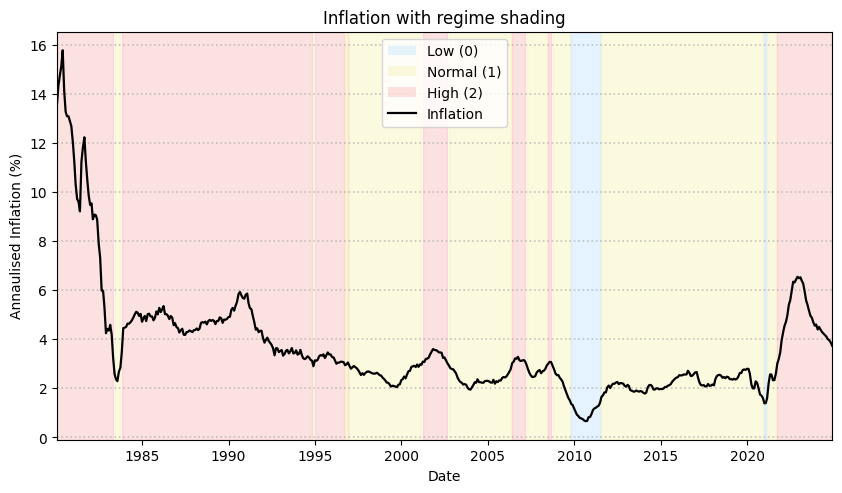

In [227]:
#Inflation!

# low rate = 0, normal rate = 1, high rate  = 2
inflation['inf_state'] = 1
inflation.loc[inflation["Inflation"] < 1.5, 'inf_state'] = 0
inflation.loc[inflation['Inflation'] >= 3, 'inf_state'] = 2

infl_plt = inflation['Inflation'].plot(figsize=(10,6), lw=1.6, color='black',
                                 title='Inflation with regime shading')

# set x-axis to the exact data range
xmin, xmax = inflation.index.min(), inflation.index.max()
infl_plt.set_xlim(xmin, xmax)

# grid
infl_plt.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
infl_plt.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)

# colours per state
state_cols = {0: "#b4deff",  # low
              1: "#f4eea3",  # normal
              2: "#f9abab"}  # high

# find contiguous blocks of the same state
blocks = (inflation['inf_state'].ne(inflation['inf_state'].shift())).cumsum()

# shade each block
for _, seg in inflation.groupby(blocks):
    st = int(seg['inf_state'].iloc[0])
    infl_plt.axvspan(seg.index[0], seg.index[-1], color=state_cols[st], alpha=0.35, zorder=0)

# centre and format year labels horizontally
infl_plt.xaxis.set_major_locator(mdates.YearLocator(5))
infl_plt.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# keep labels horizontal and centred (optional)
for lbl in infl_plt.get_xticklabels():
    lbl.set_rotation(0)
    lbl.set_ha('center')

# legend for background colours
handles = [Patch(facecolor=state_cols[0], edgecolor='none', alpha=0.35, label='Low (0)'),
           Patch(facecolor=state_cols[1], edgecolor='none', alpha=0.35, label='Normal (1)'),
           Patch(facecolor=state_cols[2], edgecolor='none', alpha=0.35, label='High (2)')]
infl_plt.legend(handles=handles + [infl_plt.lines[0]], labels=[h.get_label() for h in handles] + ['Inflation'],
          loc='best')

infl_plt.set_ylabel('Annaulised Inflation (%)')
infl_plt.set_xlabel('Date')


In [228]:
#re calculate the buckets (in case N!=4 above)
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#number of bins for the quartile inflation analysis
N = 4

#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)
data = groups.join(future_returns).dropna(subset=['fut_ret'])

#join the inflation information
data = data.join(inflation['inf_state'])

data.head()
# print(data['inf_state'].value_counts())

tvol_group  profit_group  safety_group   fut_ret  inf_state
id    date                                                                   
10001 1996-07-31           4             1             2  0.037458          2
      1996-08-30           4             1             2  0.040916          2
      1996-09-30           4             1             1 -0.028987          1
      1996-10-31           4             1             1  0.028988          1
      1996-11-29           4             1             1 -0.061268          2

In [229]:
# test = data.groupby(['date', 'inf_state'])
factor_prefixs = ['tvol_', 'profit_', 'safety_']

tvol_b_ret = (data.groupby(['date','tvol_group'])['fut_ret'].mean().unstack('tvol_group'))
tvol_b_ret = tvol_b_ret.add_prefix('tvol_')

profit_b_ret = (data.groupby(['date','profit_group'])['fut_ret'].mean().unstack('profit_group'))
profit_b_ret = profit_b_ret.add_prefix('profit_')

safety_b_ret = (data.groupby(['date','safety_group'])['fut_ret'].mean().unstack('safety_group'))
safety_b_ret = safety_b_ret.add_prefix('safety_')

inf = data.groupby('date')['inf_state'].first()
inf_state_returns = tvol_b_ret.join(profit_b_ret).join(safety_b_ret).join(inf)

#calculate series for the top quartile performance (tqp) for each inflation state
tqp_per_state = pd.DataFrame()

for factor in range(0, 3):
    for state in range(0, 3):
        column_name = f'{factor_prefixs[factor]}4_inf{state}'
        tqp_per_state[column_name] = inf_state_returns[f'{factor_prefixs[factor]}4'].where(inf_state_returns['inf_state'].eq(state))

bench_ret = data['fut_ret'].groupby('date').mean()
tqp_per_state = tqp_per_state.join(bench_ret)

tqp_active = (
    tqp_per_state.filter(like='_inf')   # all factor-by-inflation cols
    .sub(tqp_per_state['fut_ret'], axis=0)
    .add_suffix('_active')
)

info_ratio = (tqp_active.mean()*12)/(tqp_active.std()*np.sqrt(12))
print(info_ratio)


summary = pd.DataFrame({
    'n'      : tqp_active.count(),          # non-NaN months
    'mean_m' : tqp_active.mean(),           # monthly mean active
    'sd_m'   : tqp_active.std(ddof=1),      # monthly std (sample)
})

# 2) Standard error and t-stat of the mean (H0: mean == 0)
summary['se_m'] = summary['sd_m'] / np.sqrt(summary['n'])
summary['t_stat_mean'] = summary['mean_m'] / summary['se_m']

summary # to show low T_stat_mean and statistical significance of inflation state 2


tvol_4_inf0_active     -0.872323
tvol_4_inf1_active      0.585254
tvol_4_inf2_active      0.847530
profit_4_inf0_active   -0.646323
profit_4_inf1_active    0.939362
profit_4_inf2_active    1.602335
safety_4_inf0_active   -0.548634
safety_4_inf1_active    0.581998
safety_4_inf2_active    1.126126
dtype: float64


,n,mean_m,sd_m,se_m,t_stat_mean
tvol_4_inf0_active,23,-0.005438,0.021593,0.004503,-1.207676
tvol_4_inf1_active,251,0.004631,0.027411,0.001730,2.676645
tvol_4_inf2_active,254,0.004886,0.019971,0.001253,3.899251
profit_4_inf0_active,23,-0.002033,0.010895,0.002272,-0.894794
profit_4_inf1_active,251,0.003052,0.011255,0.000710,4.296148
profit_4_inf2_active,254,0.004267,0.009224,0.000579,7.371903
safety_4_inf0_active,23,-0.002527,0.015957,0.003327,-0.759549
safety_4_inf1_active,251,0.002843,0.016921,0.001068,2.661754
safety_4_inf2_active,254,0.003772,0.011604,0.000728,5.180995


3. BACK TESTING RESULTS


              tvol_active  safety_active  profit_active
Mean Return      0.009355       0.008477       0.016307
St. Dev.         0.048045       0.053034       0.043318
RR Ratio         0.194716       0.159838       0.376437
% Positive       0.502451       0.507353       0.529412
Worst Month     -0.070549      -0.075224      -0.039940
Best Month       0.113620       0.063172       0.048463
Max DrawDown    -0.130479      -0.147880      -0.117684


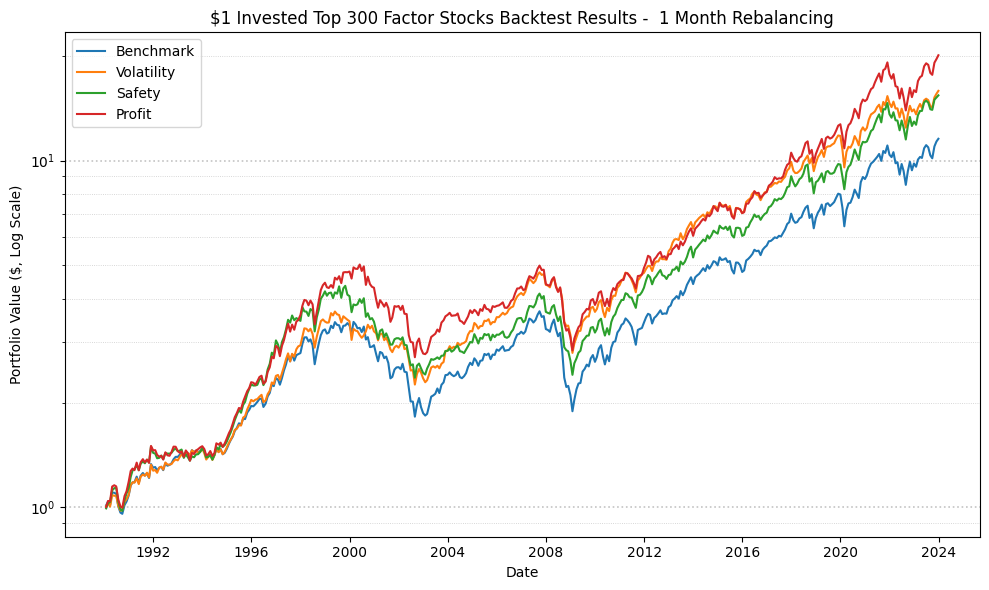

In [230]:
tvol_monthly_returns, tvol_turnover, tvol_composition, tvol_performance = ap.backtesting(factors['tvol'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)
safety_monthly_returns, safety_turnover, safety_composition, safety_performance = ap.backtesting(factors['safety'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)
profit_monthly_returns, profit_turnover, profit_composition, profit_performance = ap.backtesting(factors['profit'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)

bt_perf_table = pd.DataFrame()
bt_perf_table['tvol_active'] = tvol_performance['Active']
bt_perf_table['safety_active'] = safety_performance['Active']
bt_perf_table['profit_active'] = profit_performance['Active']
print(bt_perf_table)

tvol_bt_port = tvol_monthly_returns.cumsum().apply(np.exp)
safety_bt_port = safety_monthly_returns.cumsum().apply(np.exp)
profit_bt_port = profit_monthly_returns.cumsum().apply(np.exp)

bt_plot_perf = pd.DataFrame()
bt_plot_perf['Benchmark'] = tvol_bt_port['Benchmark'] 
bt_plot_perf['Volatility'] = tvol_bt_port['Portfolio'] 
bt_plot_perf['Safety'] = safety_bt_port['Portfolio'] 
bt_plot_perf['Profit'] = profit_bt_port['Portfolio'] 

one_dollar_invested_plot(bt_plot_perf, "$1 Invested Top 300 Factor Stocks Backtest Results -  1 Month Rebalancing")

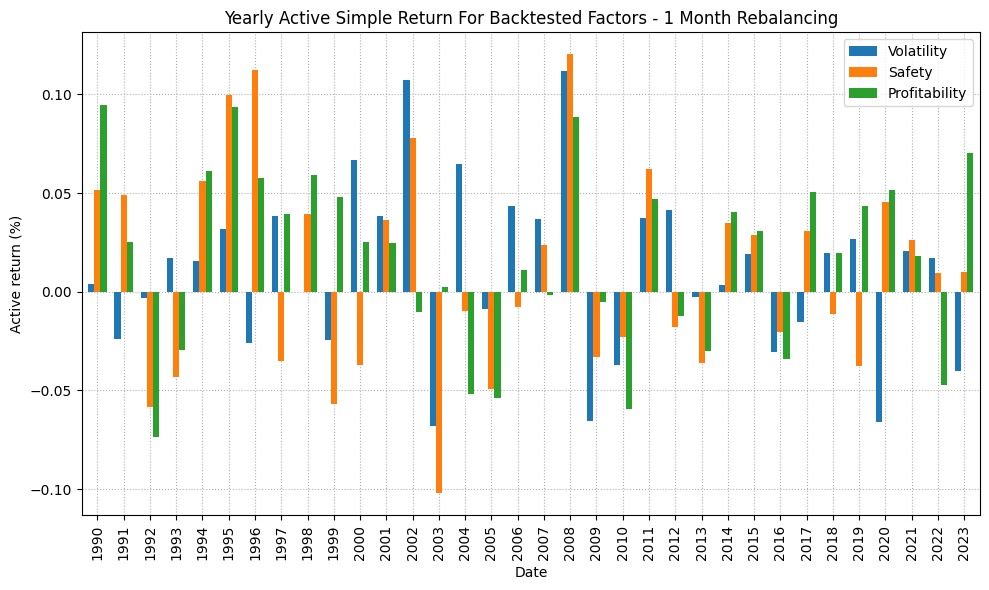

In [231]:
bt_yby = pd.DataFrame({
    'Volatility':    tvol_monthly_returns['Active'].resample('YE').sum(),
    'Safety':        safety_monthly_returns['Active'].resample('YE').sum(),
    'Profitability': profit_monthly_returns['Active'].resample('YE').sum(),
}).apply(np.expm1)
bt_yby.index = bt_yby.index.year

bt_yby_bar = bt_yby.plot(figsize=(10, 6), kind='bar',  width=0.7)
bt_yby_bar.set_title("Yearly Active Simple Return For Backtested Factors - 1 Month Rebalancing")
bt_yby_bar.set_xlabel("Date")
bt_yby_bar.set_ylabel("Active return (%)")
bt_yby_bar.grid(True, axis='both', linestyle=':', linewidth=0.8)
bt_yby_bar.set_axisbelow(True)
plt.tight_layout()
plt.show()

4. REBALANCING FREQUENCY OPTIMISATION


In [232]:
rebalancing_freq = {
    'tvol': 0,
    'safety': 0,
    'profit': 0,
}
factor_names = ['tvol', 'safety', 'profit']
frequencies = range(1, 7)
ir_values = pd.DataFrame(index=frequencies, columns=factor_names, dtype=float)

skip_optimisation = True
if skip_optimisation is not True:
    for factor in factor_names:
        max_IC = -np.inf
        for frequency in frequencies:
            print(f'calculating {factor} frequency: {frequency}')
            _, _, _, perf = ap.backtesting(factors[factor], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=frequency, t_cost=0.0015, N=300)
            ir_values.loc[frequency, factor] = perf.loc['RR Ratio', 'Active']
            if perf.loc['RR Ratio', 'Active'] > max_IC:
                max_IC = perf.loc['RR Ratio', 'Active']
                rebalancing_freq[factor] = frequency

    print(rebalancing_freq)


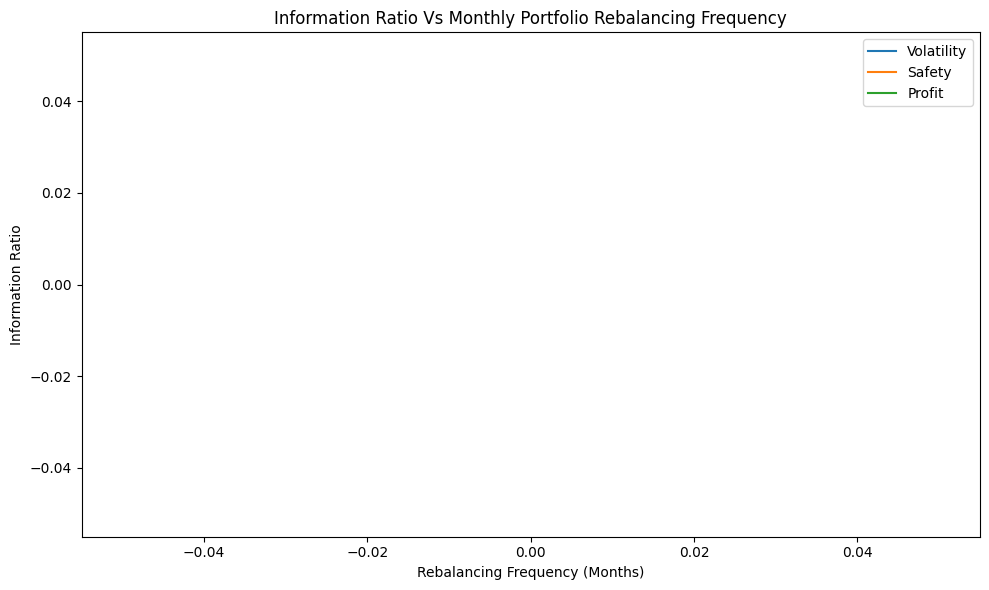

In [233]:
ir_values_plot = ir_values.plot(figsize=(10, 6))
ir_values_plot.set_title("Information Ratio Vs Monthly Portfolio Rebalancing Frequency")
ir_values_plot.set_ylabel("Information Ratio")
ir_values_plot.set_xlabel("Rebalancing Frequency (Months)")

legend_map = {
        "tvol" : "Volatility",
        "safety" : "Safety",
        "profit" : "Profit",
}
handles, labels = ir_values_plot.get_legend_handles_labels()
ir_values_plot.legend(handles, [legend_map.get(l, l) for l in labels])
ir_values_plot.figure.tight_layout()

#need to check this why is it below 0.5?

5. OPTIMAL FACTOR COMBINATION


In [234]:
combo_data = factors.join(future_returns.to_frame())



# dflt_fac_w = 1/3
# fac_cols = ['tvol', 'profit', 'safety']
# weight_cols = [f'{fac_cols[i]}_w' for i in range(len(fac_cols))]

# def monthly_ic(df, factor):
#     # df indexed by ['id','date'] with columns [factor, 'fut_ret']
#     # Spearman IC per month (cross-sectional)
#     return (df[[factor, 'fut_ret']]
#             .dropna()
#             .groupby('date')
#             .apply(lambda g: g[factor].corr(g['fut_ret'], method='spearman'))
#             .rename(f'{factor}_IC'))

# # all factors in one table
# ic_table = pd.concat([monthly_ic(combo_data, f) for f in fac_cols], axis=1)
# # optional: inspect summary stats
# ic_summary = ic_table.agg(['mean','std','count'])
# factor_multi = ic_table.rolling(6, min_periods=3).mean().shift(1) + 1 #shift IC back one to avoid look ahead



# rolls = [i for i in range(1, 96, 4)]
# results = {}
# for roll in rolls:
#     fac_weights = pd.DataFrame()
#     local_factor_multi_roll = ic_table.rolling(roll).mean().shift(1) + 1
#     local_factor_multi_roll = np.exp(local_factor_multi_roll/0.02)
#     for i, fac in enumerate(fac_cols):
#         fac_weights[f'{fac}_w'] = local_factor_multi_roll[f'{fac}_IC'] #* dflt_fac_w 
#         # fac_weights[f'{fac}_w'] = dflt_fac_w 

#     row_sum = fac_weights.sum(axis=1, skipna=True, min_count=1)   # NaN if entire row is NaN
#     norm = fac_weights.div(row_sum, axis=0)                       # divide each row by its sum
#     fac_weights = norm.mask(row_sum == 0)

#     # print(fac_weights)
#     # print(fac_weights.agg(['std']))

#     local_combo_data = combo_data.join(fac_weights, on='date')
#     local_combo_data['combo_factor'] = local_combo_data[fac_cols].mul(local_combo_data[weight_cols].values).sum(axis=1)

#     _, _, _, perf = ap.backtesting(local_combo_data['combo_factor'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=100)
    
#     perf_ic = perf.loc['RR Ratio', 'Active']
#     print(f'roll: {roll}, IR: {perf_ic}')
#     results[f'roll"{roll}'] = perf_ic

def train_tree(data: pd.DataFrame, train_start_date: str = '1990-01-01', train_end_date: str = '2014-12-31', test_start_date: str = '2015-01-01', test_end_date: str = '2023-12-29', y_col: str = 'fut_ret', depth: int = 3):
    X = data.drop(columns=[y_col])
    y = data[y_col] > data.groupby('date')[y_col].transform('median')
    X_train = X.loc[pd.IndexSlice[:, train_start_date:train_end_date],:]
    X_test = X.loc[pd.IndexSlice[:, test_start_date:test_end_date],:]
    y_train = y.loc[pd.IndexSlice[:, train_start_date:train_end_date]]
    y_test = y.loc[pd.IndexSlice[:, test_start_date:test_end_date]]
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    #calculate the feature importance
    # clf.feature_importances_
    features = pd.DataFrame(clf.feature_importances_, columns=['Feature Importance'], index=X.columns)

    # in sample predictions
    y_train_pred = clf.predict(X_train)
    # Out-of-sample predictions
    y_test_pred = clf.predict(X_test)
    os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
    ins_pred = pd.Series(y_train_pred.astype('int64'), index = X_train.index).rename('Winner')
    ret, os_dia = ap.ml_analysis(os_pred, prices.squeeze())
    print(os_dia)
    ir = os_dia.loc['RR Ratio', 'Active']

    ins_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    os_accuracy = metrics.accuracy_score(y_test, y_test_pred)

    print(f'in sample accuracy: {ins_accuracy}, out of sample accuracy: {os_accuracy}')

    return clf, ins_accuracy, os_accuracy, ir, features, X.columns.to_list()





6. MACHINE LEARNING FACTOR INVESTING APPROACH

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.016631  0.047872   0.017079  0.030793  0.064503
St. Dev.      0.239220  0.176289   0.204071  0.042487  0.088953
RR Ratio     -0.069524  0.271554   0.083691  0.724769  0.725142
% Positive    0.546296  0.620370   0.564815  0.601852  0.601852
Worst Month  -0.333519 -0.215034  -0.272953 -0.043396 -0.092804
Best Month    0.200395  0.137850   0.168014  0.057919  0.118485
Max DrawDown -0.572392 -0.353140  -0.439564 -0.167753 -0.351426
in sample accuracy: 0.5416492012481953, out of sample accuracy: 0.513625200124056
feature_importance: 
         Feature Importance
tvol              0.362681
profit            0.316429
safety            0.320890


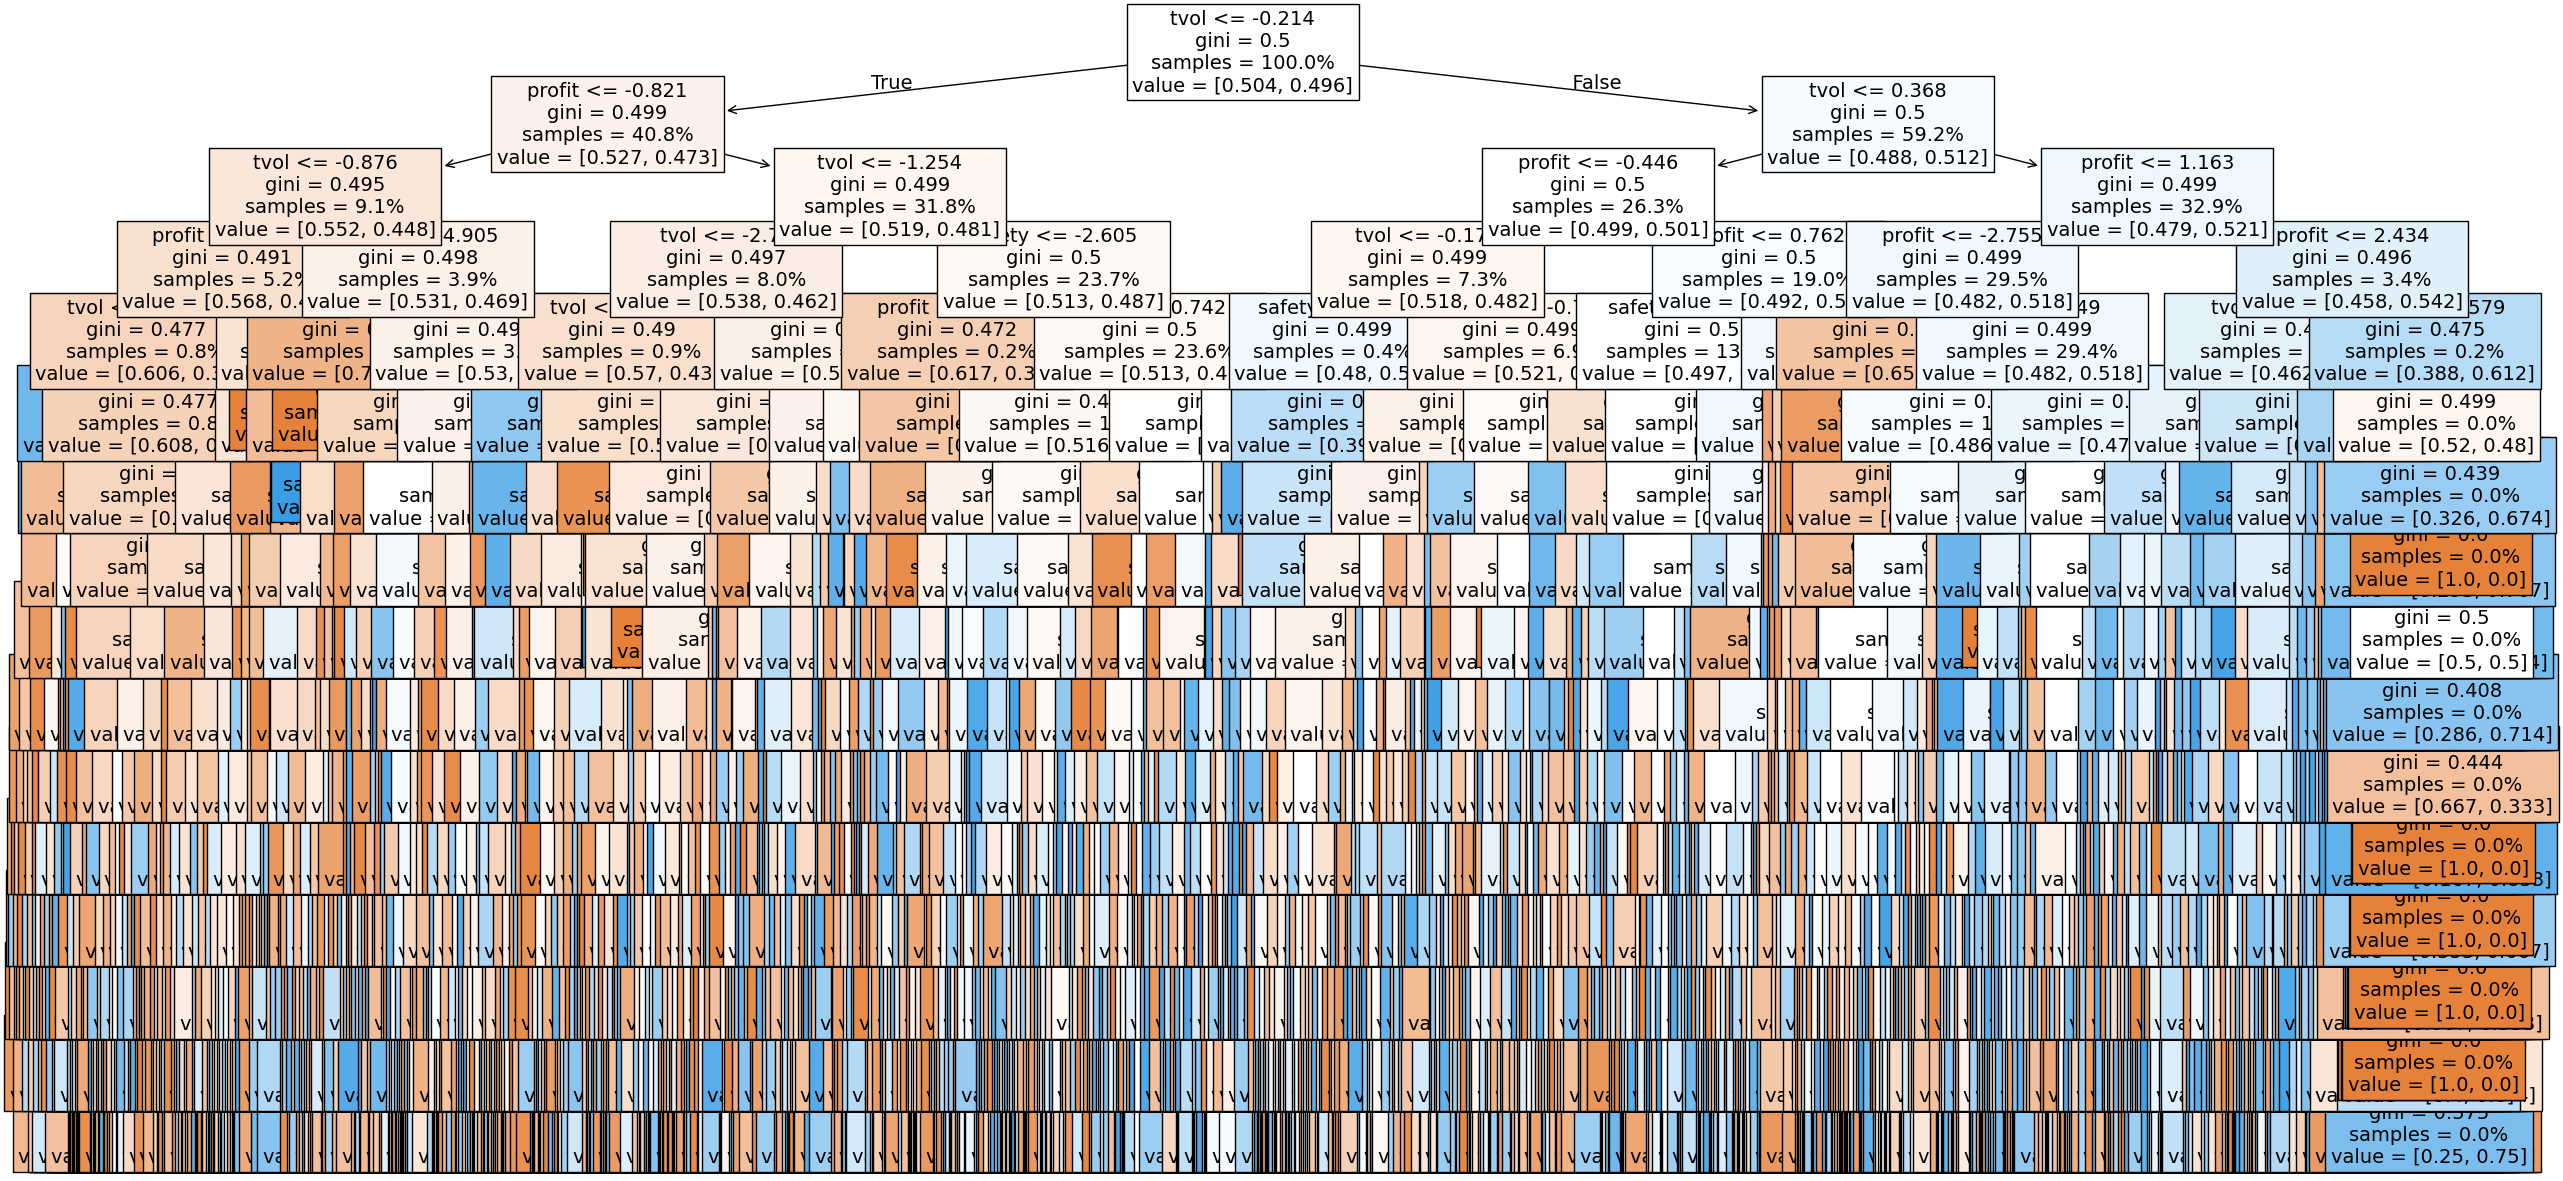

In [235]:

#calculate a decision tree for combo data
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data, depth=15)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')


In [236]:
combo_data_inf = combo_data.join(inflation['Inflation'])


                     0         1  Benchmark    Active   Neutral
Mean Return   0.000317  0.031726   0.017079  0.014647  0.031409
St. Dev.      0.224623  0.191493   0.204071  0.032477  0.071500
RR Ratio      0.001410  0.165676   0.083691  0.451000  0.439287
% Positive    0.564815  0.601852   0.564815  0.574074  0.574074
Worst Month  -0.324811 -0.231204  -0.272953 -0.042994 -0.098471
Best Month    0.195783  0.150072   0.168014  0.041749  0.093608
Max DrawDown -0.527477 -0.369746  -0.439564 -0.090831 -0.214725
in sample accuracy: 0.5754855386335057, out of sample accuracy: 0.5062153712039296
feature_importance: 
            Feature Importance
tvol                 0.290643
profit               0.240594
safety               0.249821
Inflation            0.218941
['tvol', 'profit', 'safety', 'Inflation']


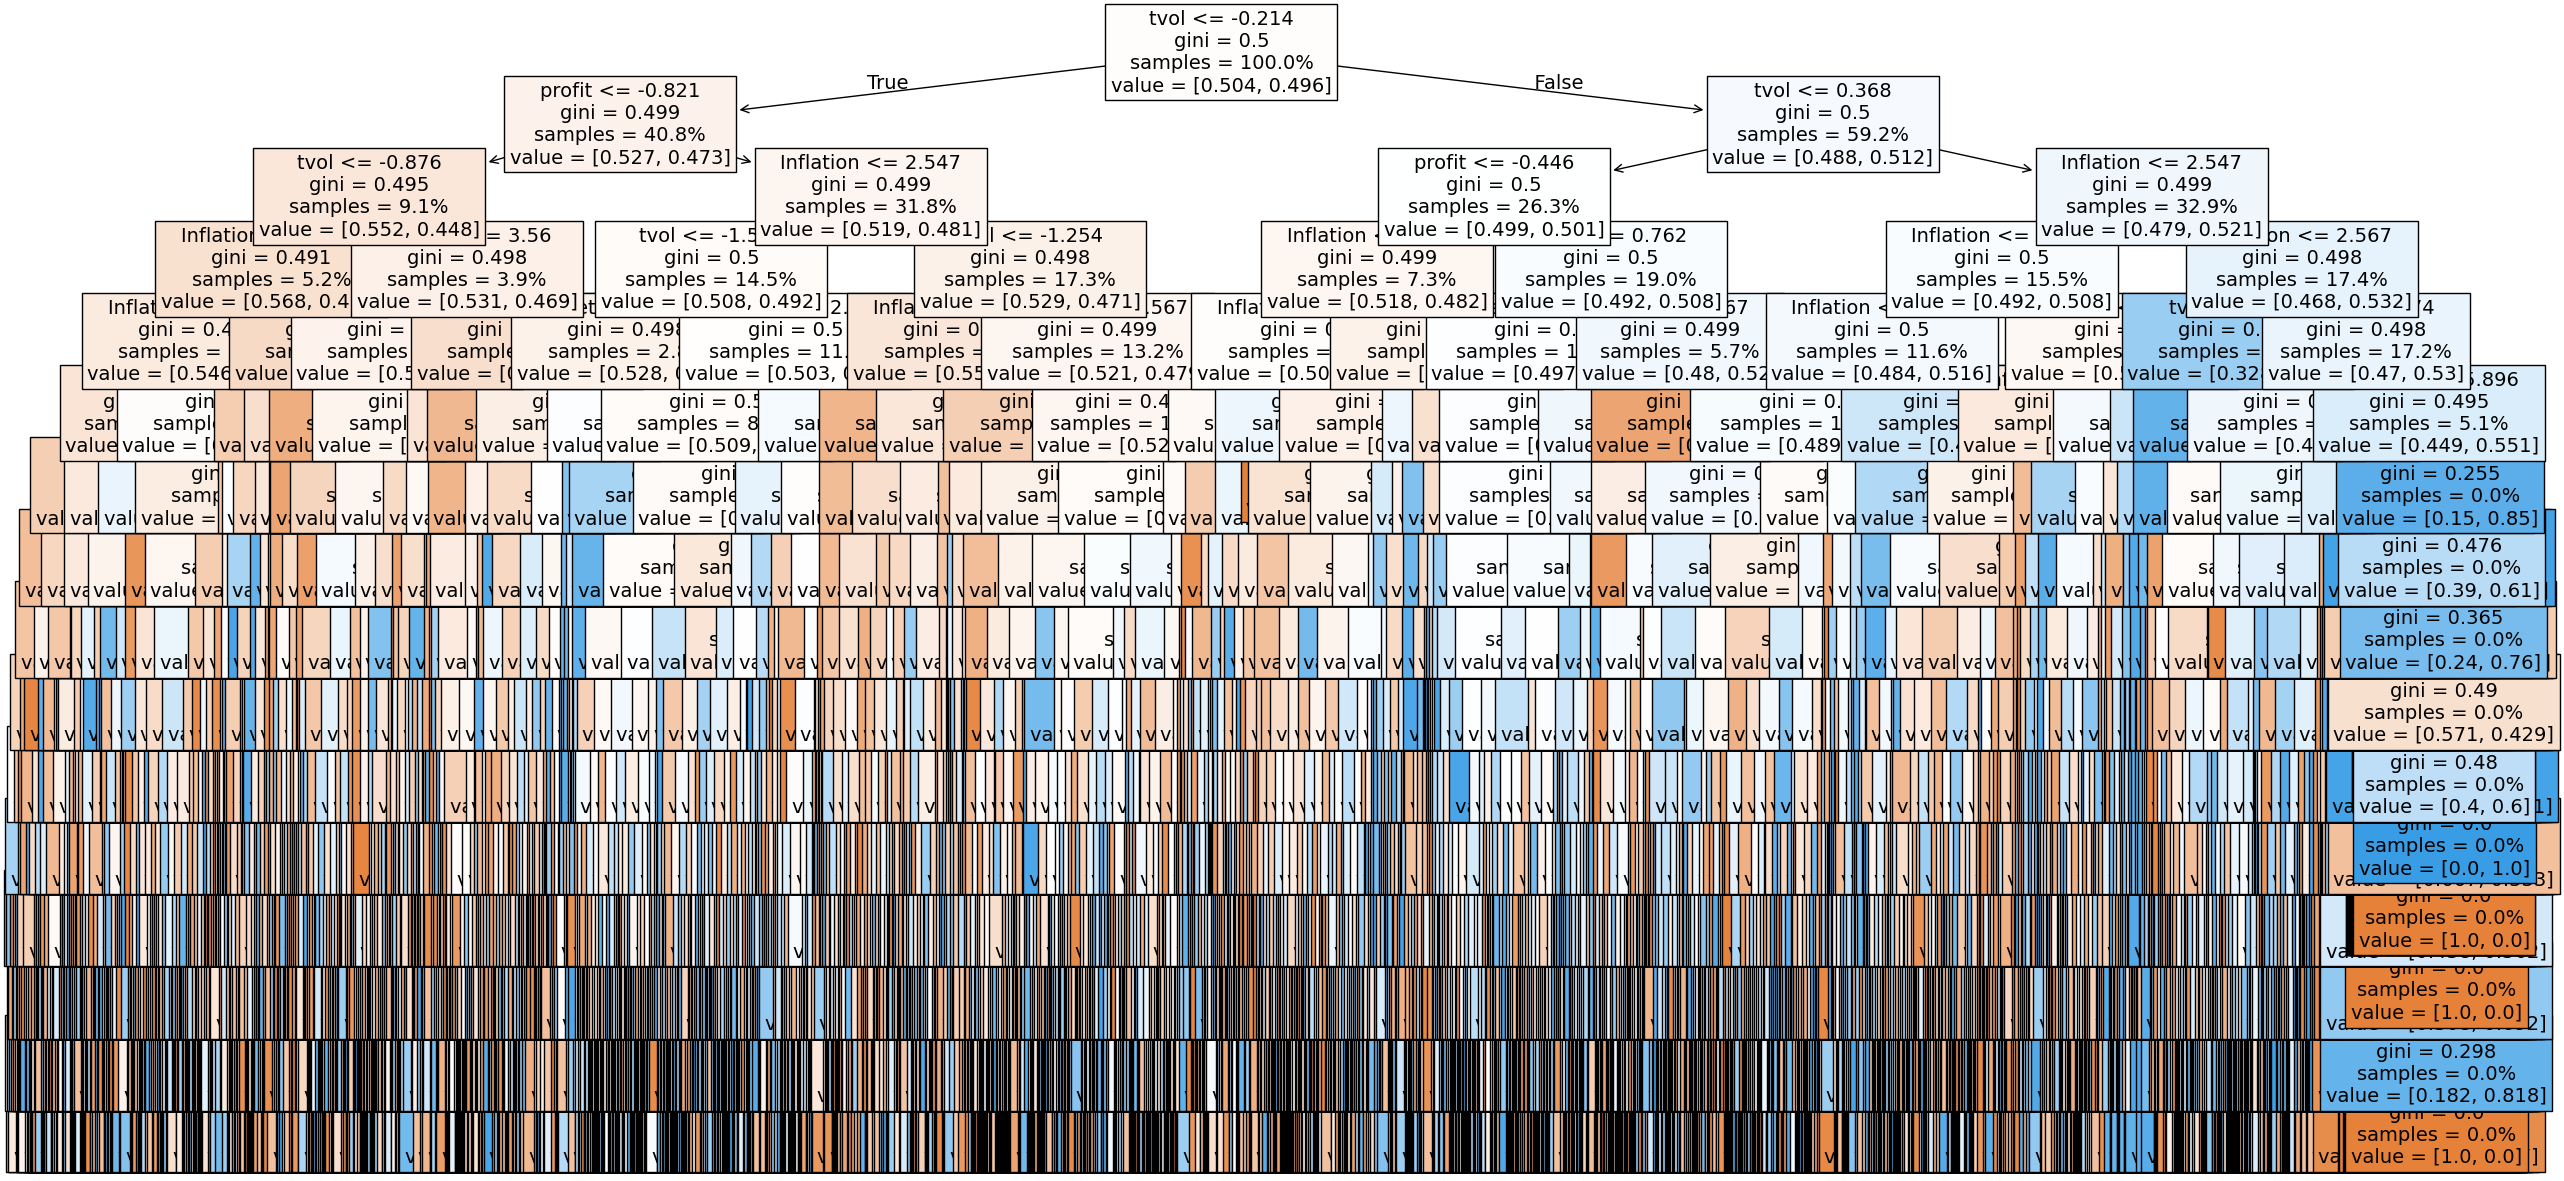

In [237]:
#re run tree with inflation variable
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data_inf, depth=15)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)

In [238]:


combo_data_infchg = combo_data.join(inflation['Inflation'])
combo_data_infchg['inf_chng'] = combo_data_infchg['Inflation']/combo_data_infchg['Inflation'].shift(1)
combo_data_infchg = combo_data_infchg.drop(columns=['Inflation'])
combo_data_infchg.head()

tvol    profit    safety   fut_ret  inf_chng
id    date                                                        
10001 1996-07-31  1.145514 -0.612134 -0.475430  0.037458       NaN
      1996-08-30  1.144505 -0.614493 -0.553341  0.040916  0.993390
      1996-09-30  1.144190 -1.327119 -0.697980 -0.028987  0.961037
      1996-10-31  1.124252 -1.324461 -0.728012  0.028988  1.012450
      1996-11-29  1.123180 -1.321322 -0.721799 -0.061268  1.025511

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.030845  0.061335   0.017079  0.044256  0.092179
St. Dev.      0.228849  0.187136   0.204071  0.039972  0.082353
RR Ratio     -0.134782  0.327754   0.083691  1.107177  1.119322
% Positive    0.527778  0.620370   0.564815  0.685185  0.685185
Worst Month  -0.273042 -0.272540  -0.272953 -0.031748 -0.067662
Best Month    0.203928  0.136266   0.168014  0.032274  0.066453
Max DrawDown -0.511232 -0.410021  -0.439564 -0.097945 -0.186121
in sample accuracy: 0.520882818685669, out of sample accuracy: 0.519157425335915
feature_importance: 
           Feature Importance
tvol                0.742615
profit              0.171895
safety              0.000000
inf_chng            0.085490
['tvol', 'profit', 'safety', 'inf_chng']


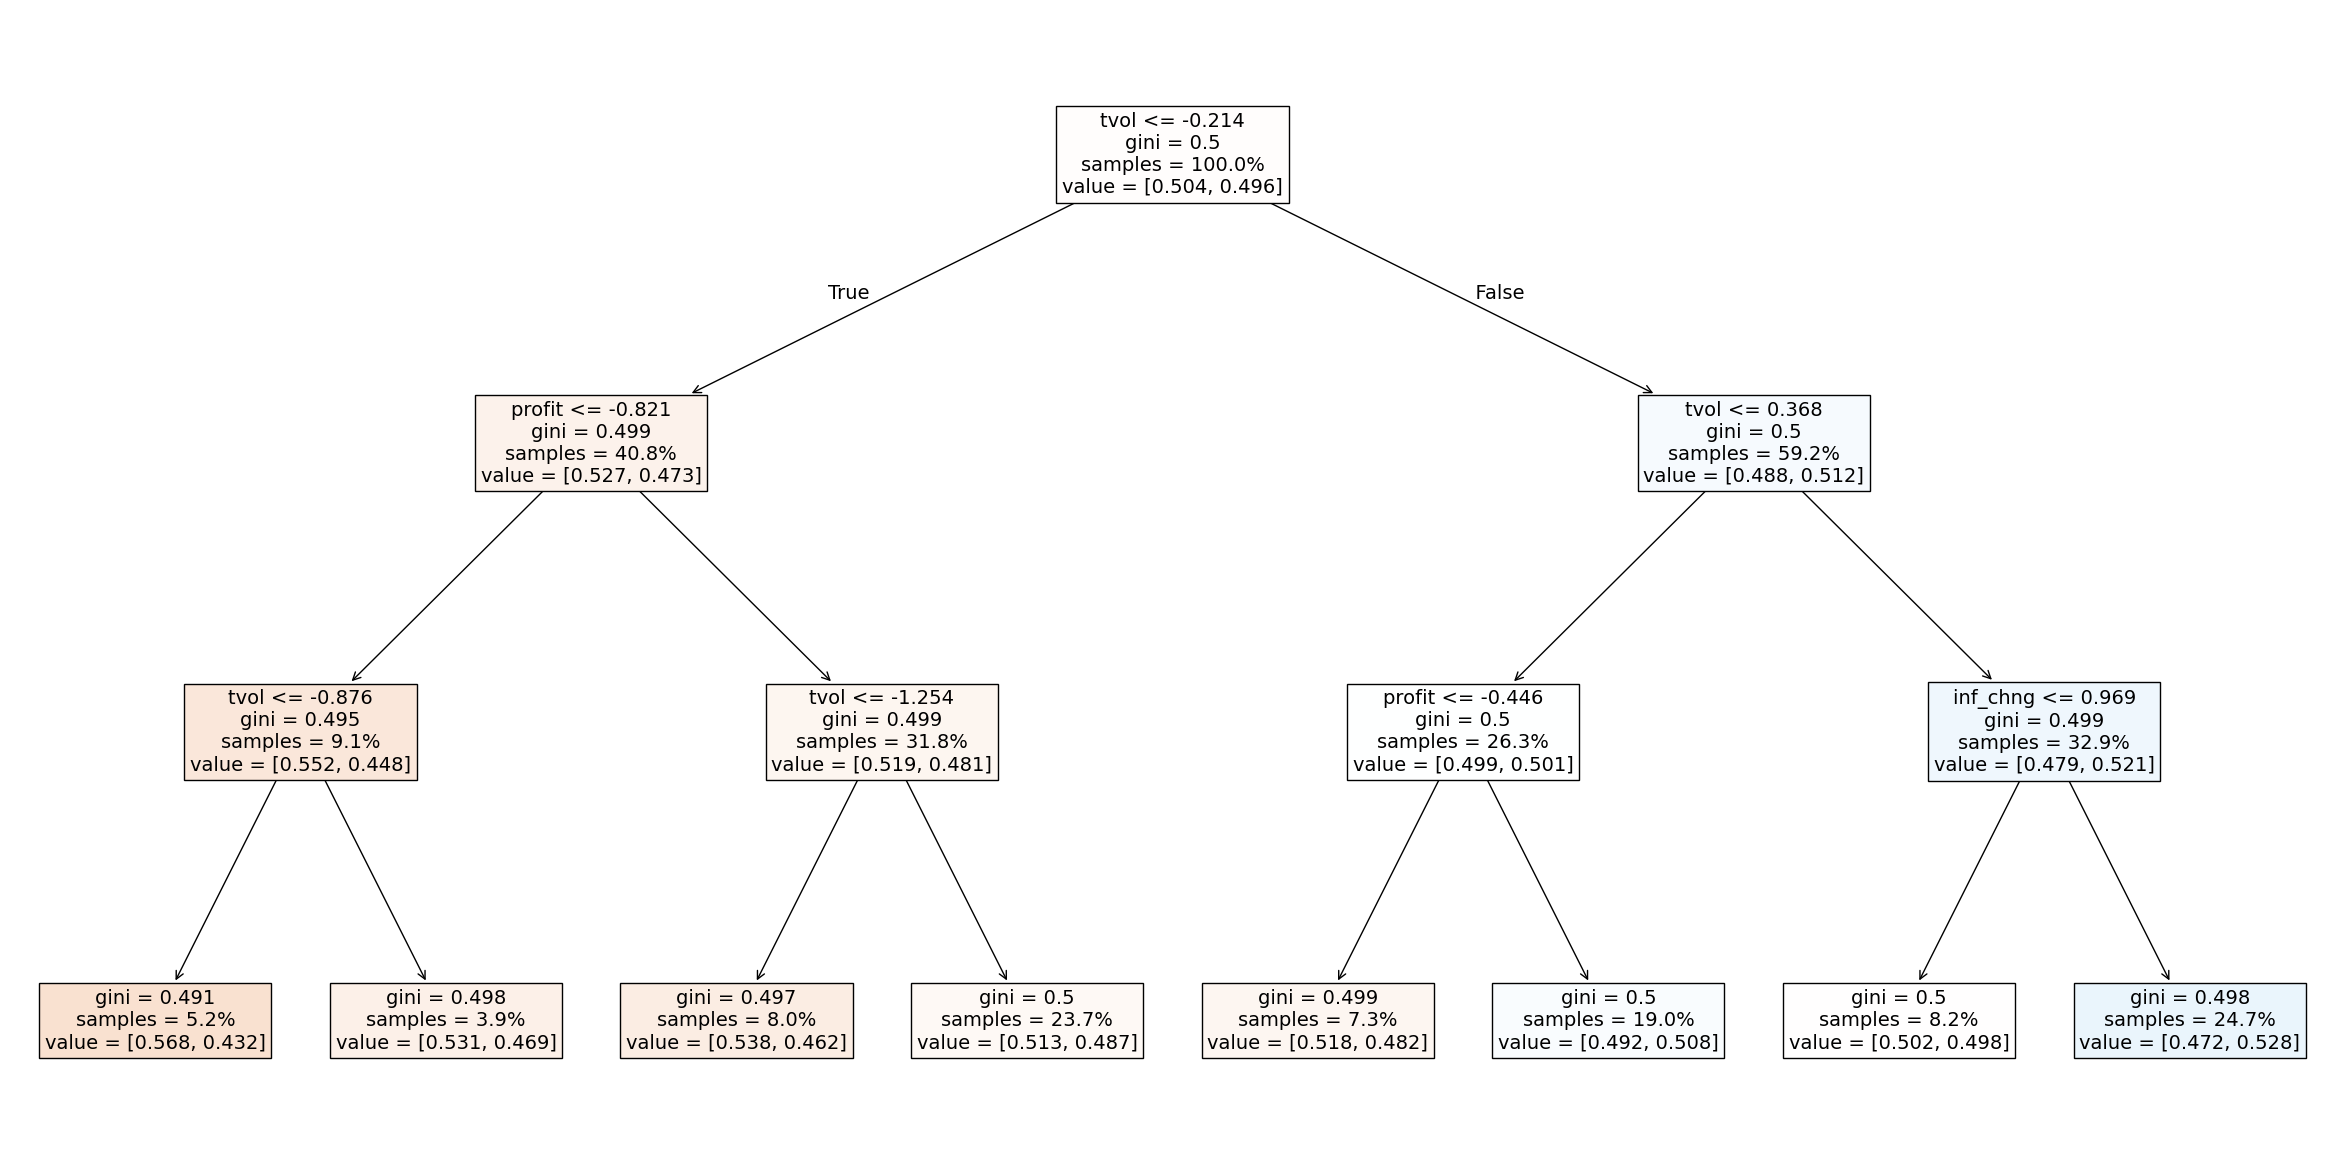

In [239]:
#re run tree with inflation change
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data_infchg)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)


In [240]:
inf_dums = pd.get_dummies(inflation['inf_state'], prefix='inf_state', dtype=int) #convert to individual columns 
inf_tree_data = combo_data.join(inf_dums, on='date')

facs = ['tvol', 'profit', 'safety']
states = [c for c in inf_tree_data.columns if c.startswith('inf_state_')]

for fac in facs:
    for state in states:
        inf_tree_data[f'{fac}__{state}'] = inf_tree_data[fac] * inf_tree_data[state]

inf_tree_data.head()


tvol    profit    safety   fut_ret  inf_state_0  \
id    date                                                              
10001 1996-07-31  1.145514 -0.612134 -0.475430  0.037458            0   
      1996-08-30  1.144505 -0.614493 -0.553341  0.040916            0   
      1996-09-30  1.144190 -1.327119 -0.697980 -0.028987            0   
      1996-10-31  1.124252 -1.324461 -0.728012  0.028988            0   
      1996-11-29  1.123180 -1.321322 -0.721799 -0.061268            0   

                  inf_state_1  inf_state_2  tvol__inf_state_0  \
id    date                                                      
10001 1996-07-31            0            1                0.0   
      1996-08-30            0            1                0.0   
      1996-09-30            1            0                0.0   
      1996-10-31            1            0                0.0   
      1996-11-29            0            1                0.0   

                  tvol__inf_state_1  tvol__inf_state_2  profit__inf_state_0  \
id    date                                                                    
10001 1996-07-31           0.000000           1.145514                 -0.0   
      1996-08-30           0.000000           1.144505                 -0.0   
      1996-09-30           1.144190           0.000000                 -0.0   
      1996-10-31           1.124252           0.000000                 -0.0   
      1996-11-29           0.000000           1.123180                 -0.0   

                  profit__inf_state_1  profit__inf_state_2  \
id    date                                                   
10001 1996-07-31            -0.000000            -0.612134   
      1996-08-30            -0.000000            -0.614493   
      1996-09-30            -1.327119            -0.000000   
      1996-10-31            -1.324461            -0.000000   
      1996-11-29            -0.000000            -1.321322   

                  safety__inf_state_0  safety__inf_state_1  \
id    date                                                   
10001 1996-07-31                 -0.0            -0.000000   
      1996-08-30                 -0.0            -0.000000   
      1996-09-30                 -0.0            -0.697980   
      1996-10-31                 -0.0            -0.728012   
      1996-11-29                 -0.0            -0.000000   

                  safety__inf_state_2  
id    date                             
10001 1996-07-31            -0.475430  
      1996-08-30            -0.553341  
      1996-09-30            -0.000000  
      1996-10-31            -0.000000  
      1996-11-29            -0.721799

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.028216  0.057543   0.017079  0.040464  0.085759
St. Dev.      0.245578  0.173608   0.204071  0.049543  0.105132
RR Ratio     -0.114896  0.331455   0.083691  0.816761  0.815730
% Positive    0.518519  0.620370   0.564815  0.648148  0.648148
Worst Month  -0.335507 -0.213798  -0.272953 -0.050638 -0.108292
Best Month    0.203964  0.136353   0.168014  0.059155  0.121709
Max DrawDown -0.573584 -0.351279  -0.439564 -0.172271 -0.365832
in sample accuracy: 0.5205771738624191, out of sample accuracy: 0.5180845089311908
feature_importance: 
                      Feature Importance
tvol                           0.788037
profit                         0.182409
safety                         0.000000
inf_state_0                    0.000000
inf_state_1                    0.000000
inf_state_2                    0.000000
tvol__inf_state_0              0.000000
tvol__inf_state_1              0.000000
tvol__inf_state_2      

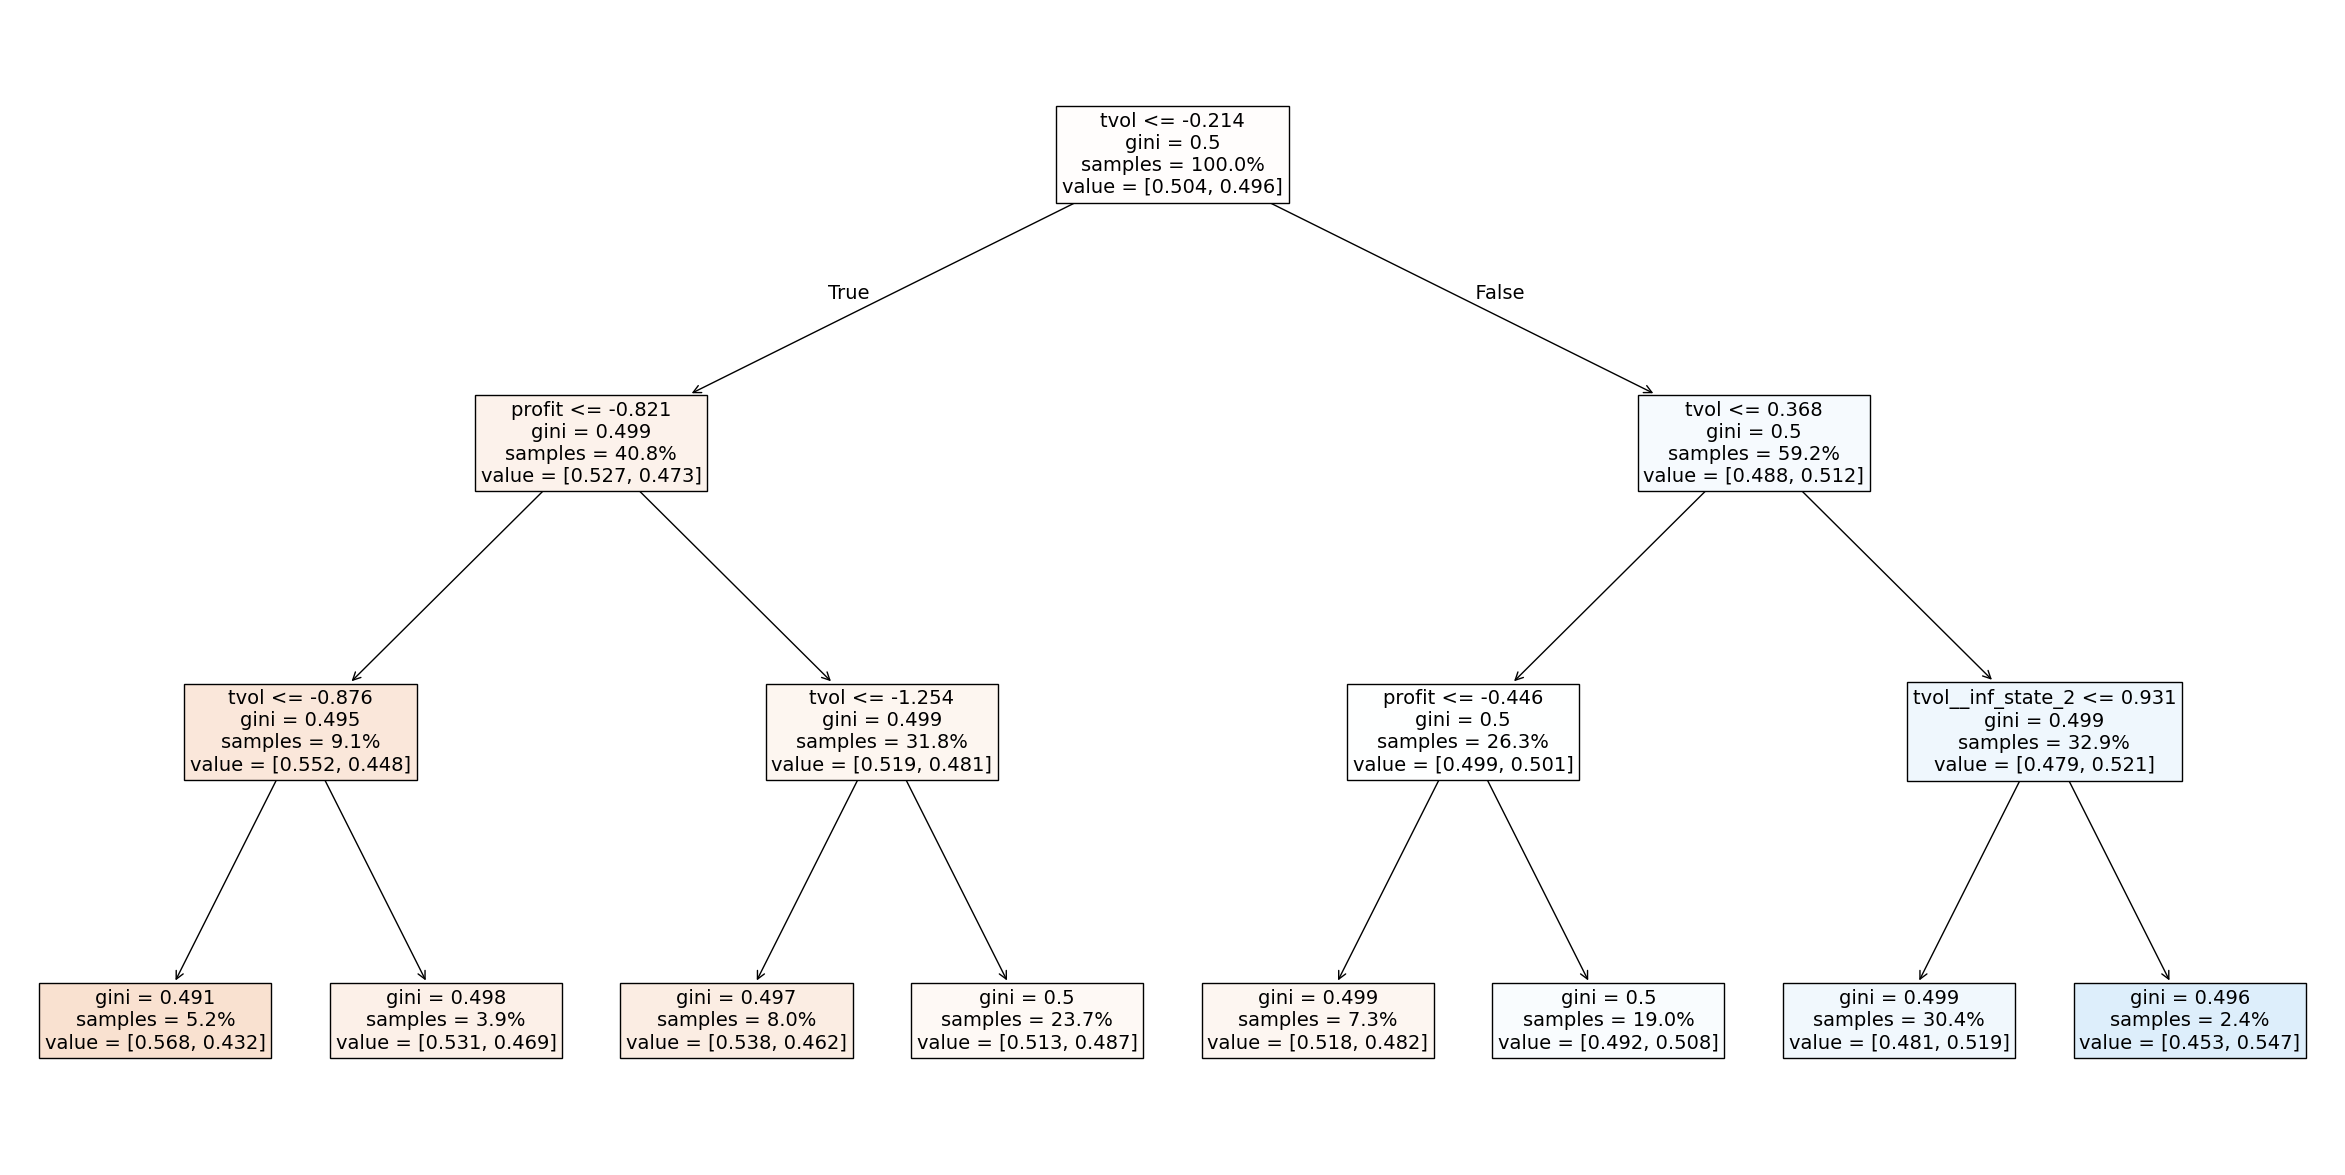

In [241]:
#re run tree with inflation states
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(inf_tree_data)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)
